In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'f4d5585be98d4a0dba93f5deec36e107')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'blåmes')
ims = results.attrgot('contentUrl')
len(ims)

150

In [6]:
#hide
ims = ['https://upload.wikimedia.org/wikipedia/commons/8/86/Eurasian_blue_tit_Lancashire.jpg']

In [7]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

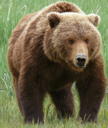

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
bear_types = 'blåmes','taljoxe','gråsparv'
path = Path('faglar')

In [10]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} fågel')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
fns = get_image_files(path)
fns

(#405) [Path('faglar/gråsparv/00000047.jpg'),Path('faglar/gråsparv/00000055.jpg'),Path('faglar/gråsparv/00000034.png'),Path('faglar/gråsparv/00000107.jpg'),Path('faglar/gråsparv/00000148.jpg'),Path('faglar/gråsparv/00000110.jpg'),Path('faglar/gråsparv/00000112.jpg'),Path('faglar/gråsparv/00000093.jpg'),Path('faglar/gråsparv/00000090.jpg'),Path('faglar/gråsparv/00000135.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#0) []

In [13]:
failed.map(Path.unlink);

In [14]:
faglar = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = faglar.dataloaders(path)

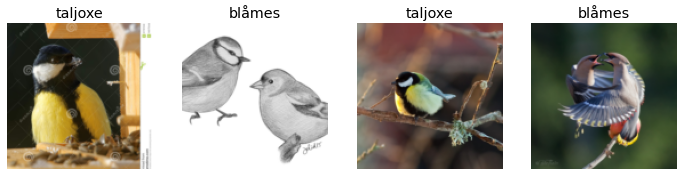

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

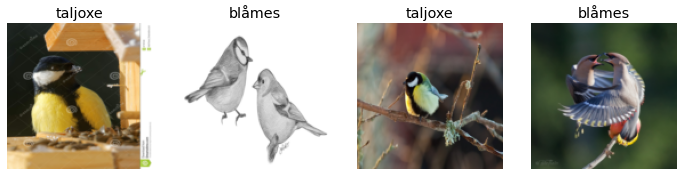

In [17]:
bears = faglar.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

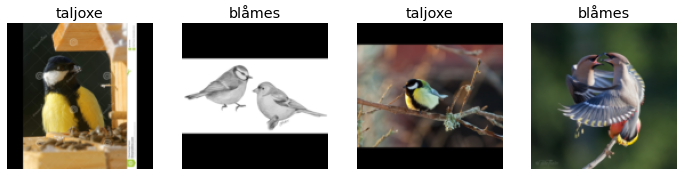

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

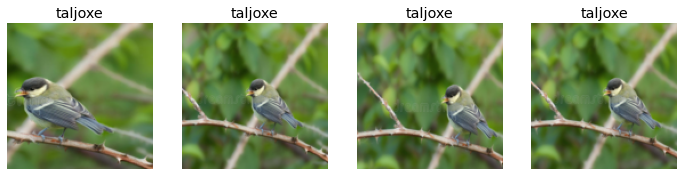

In [19]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

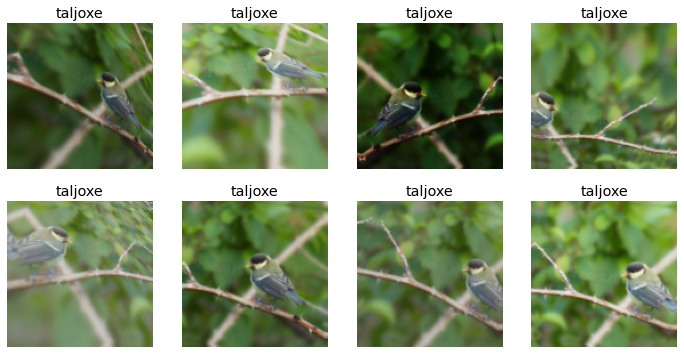

In [20]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [21]:
faglar = faglar.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = faglar.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.478489,1.271078,0.493827,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.943063,0.824031,0.345679,00:09
1,0.781049,0.928706,0.271605,00:09
2,0.673768,0.891044,0.271605,00:09
3,0.605105,0.839597,0.222222,00:09


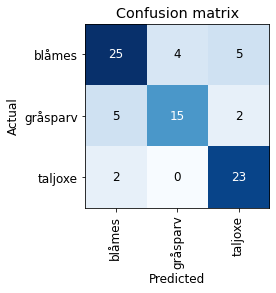

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

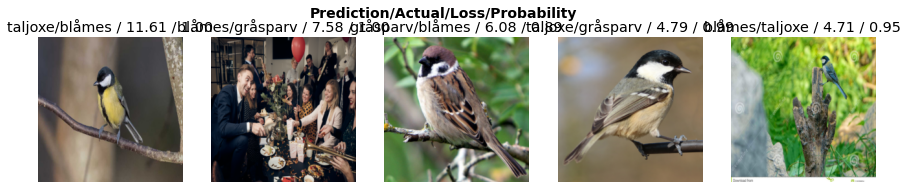

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [28]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [30]:
learn.export()

In [31]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [32]:
learn_inf = load_learner(path/'export.pkl')

In [33]:
learn_inf.predict('images/grizzly.jpg')

('blåmes', tensor(0), tensor([0.7338, 0.2516, 0.0146]))

In [46]:
learn_inf.dls.vocab

['blåmes', 'gråsparv', 'taljoxe']

In [47]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [58]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['faglar/gråsparv/00000047.jpg'])

In [59]:
img = PILImage.create(btn_upload.data[-1])

In [60]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [61]:
pred,pred_idx,probs = learn_inf.predict(img)

In [62]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: gråsparv; Probability: 0.9976')

In [63]:
#hide_output
btn_run = widgets.Button(description='Hitta min fågel!')
btn_run

Button(description='Classify', style=ButtonStyle())

In [64]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [65]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [66]:
VBox([widgets.Label('Välj din fågel!'), 
      btn_upload, btn_run, out_pl, lbl_pred])